# Часть I. Анализ характеристик для KNN-графа и дистанционного графа
# **Цель:** Исследовать поведение характеристик для двух типов графов:
# - **KNN-граф:** Характеристика — число треугольников (`count_triangles`).
# - **Дистанционный граф:** Характеристика — размер наибольшей клики в графе (`clique_number`).

### Настройка окружения
### Добавляем путь к проекту и импортируем модули.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Настройка путей
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
# Импорт пользовательских модулей
from src.distribution_generators import generate_chi2, generate_chi
from src.graph_analyzer import GraphAnalyzer
from src.monte_carlo import monte_carlo_simulation
from src.hypothesis_testing import calculate_critical_region, estimate_power
from src.visualization import plot_line, plot_critical_region


## Эксперимент 1. 
### KNN-граф: Зависимость числа треугольников от параметров распределений
### Dist-граф: Зависимость размера наибольшей клики в графе от параметров распределений
### **Параметры:**
- `n = 200`, `k = 10`, `d = 10`
- `k ∈ [3, 5, 7, 10, 12, 15, 20]`

In [36]:
n = 200
nu_values = [3, 5, 7, 10, 12, 15, 20]
n_samples = 500
fixed_knn_k = 10
fixed_dist_d = 1


In [37]:
# Симуляция для χ²(θ, ν=5)
h0_knn_stats = []
h0_dist_stats = []

for nu in tqdm(nu_values, desc="Симуляция для χ²-распределения"):
    stats_dist = monte_carlo_simulation(
        generate_chi2,
        {"nu": nu, "n": n},
        graph_type="distance",
        graph_param=fixed_dist_d,
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": fixed_dist_d},
    )
    
    stats_knn = monte_carlo_simulation(
        generate_chi2,
        {"nu": nu, "n": n},
        graph_type="knn",
        graph_param=fixed_knn_k,
        metric="count_triangles",
        n_samples=n_samples,
    )

    h0_knn_stats.append(np.mean(stats_knn))
    h0_dist_stats.append(np.mean(stats_dist))


Симуляция для χ²-распределения: 100%|██████████| 7/7 [01:05<00:00,  9.42s/it]


In [38]:
# Симуляция для χ

h1_knn_stats = []
h1_dist_stats = []
for nu in tqdm(nu_values, desc="Симуляция для χ-распределения"):
    stats_knn = monte_carlo_simulation(
        generate_chi,
        {"nu": nu, "n": n},
        graph_type="knn",
        graph_param=fixed_knn_k,
        metric="count_triangles",
        n_samples=n_samples,
    )

    stats_dist = monte_carlo_simulation(
        generate_chi,
        {"nu": nu, "n": n},
        graph_type="distance",
        graph_param=fixed_dist_d,
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": fixed_dist_d}
    )

    h1_knn_stats.append(np.mean(stats_knn))
    h1_dist_stats.append(np.mean(stats_dist))


Симуляция для χ-распределения: 100%|██████████| 7/7 [01:38<00:00, 14.12s/it]


## Визуализация

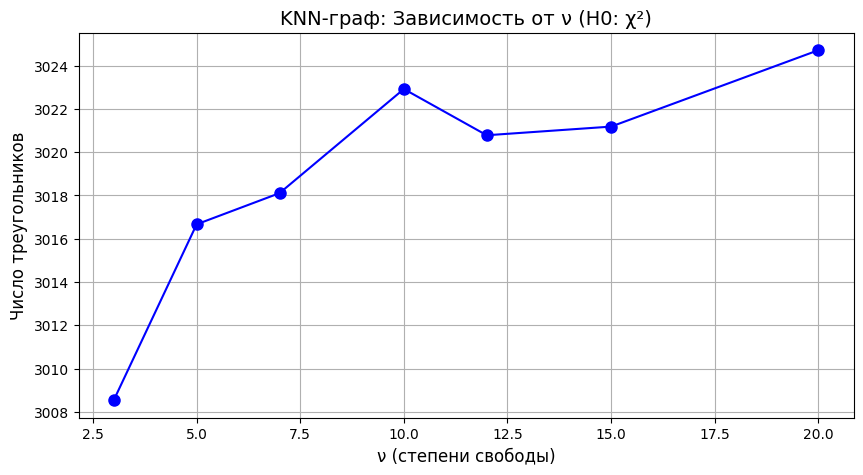

In [40]:
# Для KNN-графа
plot_line(
    x_values=nu_values,
    y_values=h0_knn_stats,
    x_label="ν (степени свободы)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от ν (H0: χ²)",
    # color="blue"
)


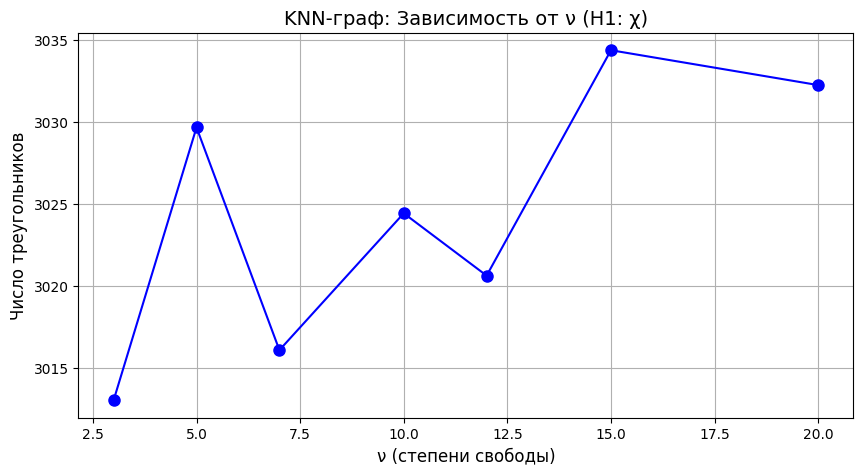

In [41]:
# Для KNN-графа
plot_line(
    x_values=nu_values,
    y_values=h1_knn_stats,
    x_label="ν (степени свободы)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от ν (H1: χ)",
    # color="orange"
)


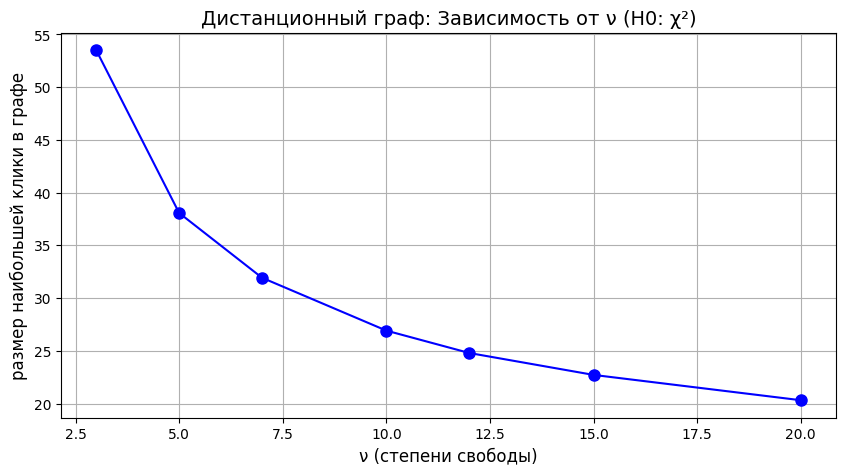

In [42]:
# Для дистанционного графа
plot_line(
    x_values=nu_values,
    y_values=h0_dist_stats,
    x_label="ν (степени свободы)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от ν (H0: χ²)",
    # color="blue"
)


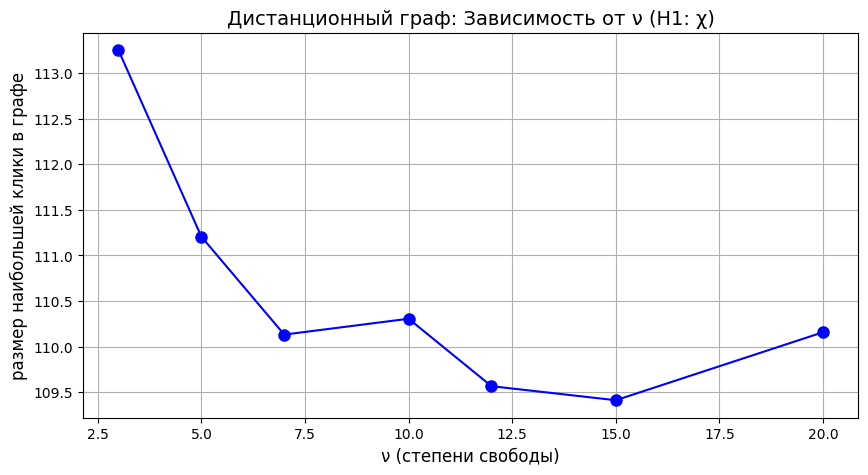

In [43]:
# Для дистанционного графа
plot_line(
    x_values=nu_values,
    y_values=h1_dist_stats,
    x_label="ν (степени свободы)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от ν (H1: χ)",
    # color="orange"
)


## Вывод из 1 эксперимента:

- **KNN-граф (k=10)**  
  Слабо различает распределения χ² и χ — число треугольников несильно отличается при любых ν.

- **Дистанционный граф**  
  различия более выражены,
  - При ν = 3:  
    - χ² → clique_number ≈ 53
    - χ  → clique_number ≈ 113 
  - Разница более чем в 2 раза


# Эксперимент 2. Зависимость характеристик от параметров графа и размера выборки
## Исследуем, как характеристики меняются при изменении:
# - Параметра `k` (KNN-граф) и `d` (дистанционный граф).
# - Размера выборки `n`.
# 
# **Фиксированные параметры:**  
# - $\theta_0 = \nu_0 = 5$ ( $\nu = 5$ для распределений $\chi^2$ и $\chi$).

In [44]:
# Конфигурация
theta0 = 5  # Фиксированный параметр распределения для χ²
nu0 = 5  # Аналогично для χ
k_values = [5, 10, 15, 20]  # Параметры KNN-графа
d_values = [0.5, 1.0, 1.5, 2.0]  # Параметры дистанционного графа
n_values = [100, 200, 300, 500]  # Размеры выборок
n_samples = 500  # Число симуляций для каждого случая
fixed_n = 300
fixed_knn_k = 10
fixed_dist_d = 1


### Зависимость от количества соседей `k`
Для KNN-графа

In [45]:
h0_knn_k_stats = []
h1_knn_k_stats = []

for k in k_values:
    # H0 (χ²)
    h0_stats = monte_carlo_simulation(
        generate_chi2,
        {"nu": theta0, "n": fixed_n},  # Фиксированный n
        graph_type="knn",
        graph_param=k,
        metric="count_triangles",
        n_samples=n_samples,
    )
    # H1 (χ)
    h1_stats = monte_carlo_simulation(
        generate_chi,
        {"nu": nu0, "n": fixed_n},  # Фиксированный n
        graph_type="knn",
        graph_param=k,
        metric="count_triangles",
        n_samples=n_samples,
    )

    h0_knn_k_stats.append(np.mean(h0_stats))
    h1_knn_k_stats.append(np.mean(h1_stats))


### Зависимость от расстояния `d`
Для Dist-графа

In [46]:
h0_dist_d_stats = []
h1_dist_d_stats = []

for d in d_values:
    # H0 (χ²)
    h0_stats = monte_carlo_simulation(
        generate_chi2,
        {"nu": theta0, "n": fixed_n},  # Фиксированный n
        graph_type="distance",
        graph_param=d,
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": d}
    )
    # H1 (χ)
    h1_stats = monte_carlo_simulation(
        generate_chi,
        {"nu": nu0, "n": fixed_n},  # Фиксированный n
        graph_type="distance",
        graph_param=d,
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": d}
    )

    h0_dist_d_stats.append(np.mean(h0_stats))
    h1_dist_d_stats.append(np.mean(h1_stats))

### Зависимость от размера выборки `n`
Для KNN-графа (k=10),

Для Dist-графа (d=1)

In [47]:
h0_knn_n_stats = []
h1_knn_n_stats = []

h0_dist_n_stats = []
h1_dist_n_stats = []


for n in n_values:
    # H0 (χ²) knn
    h0_stats = monte_carlo_simulation(
        generate_chi2,
        {"nu": theta0, "n": n},
        graph_type="knn",
        graph_param=fixed_knn_k,  # Фиксированный k
        metric="count_triangles",
        n_samples=n_samples,
    )
    # H1 (χ) knn
    h1_stats = monte_carlo_simulation(
        generate_chi,
        {"nu": nu0, "n": n},
        graph_type="knn",
        graph_param=fixed_knn_k,  # Фиксированный k
        metric="count_triangles",
        n_samples=n_samples,
    )
    h1_knn_n_stats.append(np.mean(h1_stats))
    h0_knn_n_stats.append(np.mean(h0_stats))

    # H0 (χ²) dist
    h0_stats = monte_carlo_simulation(
        generate_chi2,
        {"nu": theta0, "n": n},
        graph_type="distance",
        graph_param=fixed_dist_d,  # Фиксированный d
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": fixed_dist_d}
    )
    # H1 (χ) dist
    h1_stats = monte_carlo_simulation(
        generate_chi,
        {"nu": nu0, "n": n},
        graph_type="distance",
        graph_param=fixed_dist_d,  # Фиксированный d
        metric="clique_number",
        n_samples=n_samples,
        metric_args={"d": fixed_dist_d}
    )
    h0_dist_n_stats.append(np.mean(h1_stats))
    h1_dist_n_stats.append(np.mean(h0_stats))


In [48]:
print("h0_knn_n_stats:",h0_knn_n_stats)
print("h1_knn_n_stats:",h1_knn_n_stats)
print("h0_dist_n_stats:",h0_dist_n_stats)
print("h1_dist_n_stats:",h1_dist_n_stats)
print("h0_dist_d_stats:",h0_dist_d_stats)
print("h1_dist_d_stats:",h1_dist_d_stats)
print("h0_knn_k_stats:",h0_knn_k_stats)
print("h1_knn_k_stats:",h1_knn_k_stats)

h0_knn_n_stats: [np.float64(1595.026), np.float64(3015.112), np.float64(4432.544), np.float64(7242.304)]
h1_knn_n_stats: [np.float64(1591.39), np.float64(3019.728), np.float64(4441.726), np.float64(7258.674)]
h0_dist_n_stats: [np.float64(57.17), np.float64(111.58), np.float64(164.946), np.float64(272.672)]
h1_dist_n_stats: [np.float64(20.706), np.float64(37.924), np.float64(54.462), np.float64(87.352)]
h0_dist_d_stats: [np.float64(31.506), np.float64(54.978), np.float64(76.16), np.float64(97.72)]
h1_dist_d_stats: [np.float64(92.722), np.float64(164.562), np.float64(222.198), np.float64(260.422)]
h0_knn_k_stats: [np.float64(1038.23), np.float64(4423.004), np.float64(10206.282), np.float64(18525.798)]
h1_knn_k_stats: [np.float64(1039.734), np.float64(4437.498), np.float64(10230.558), np.float64(18605.944)]


## Визуализация

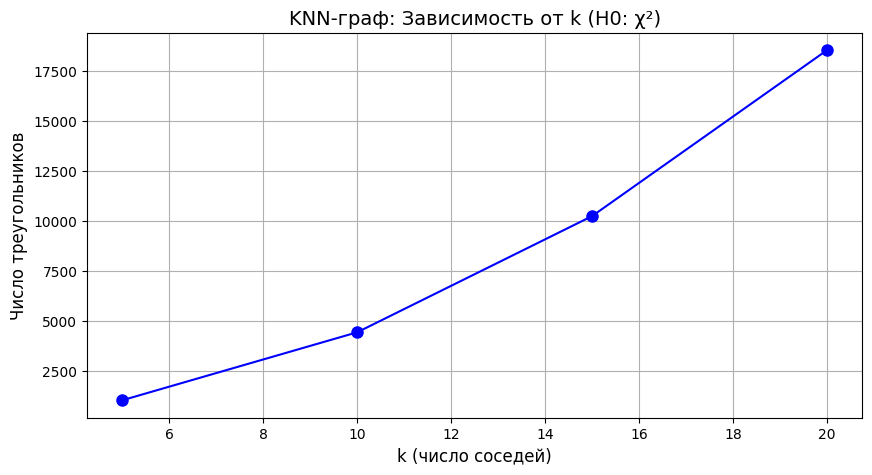

In [18]:
plot_line(
    x_values=k_values,
    y_values=h0_knn_k_stats,
    x_label="k (число соседей)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от k (H0: χ²)",
    # color="blue"
)

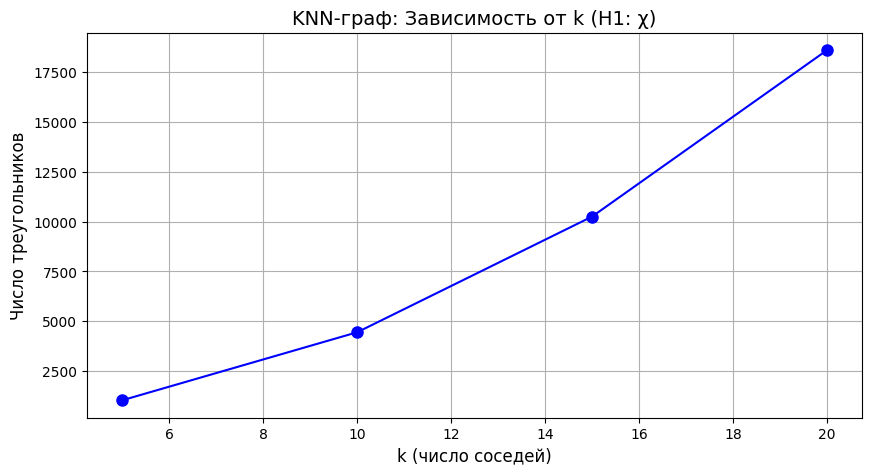

In [19]:
plot_line(
    x_values=k_values,
    y_values=h1_knn_k_stats,
    x_label="k (число соседей)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от k (H1: χ)",
    # color="orange"
)


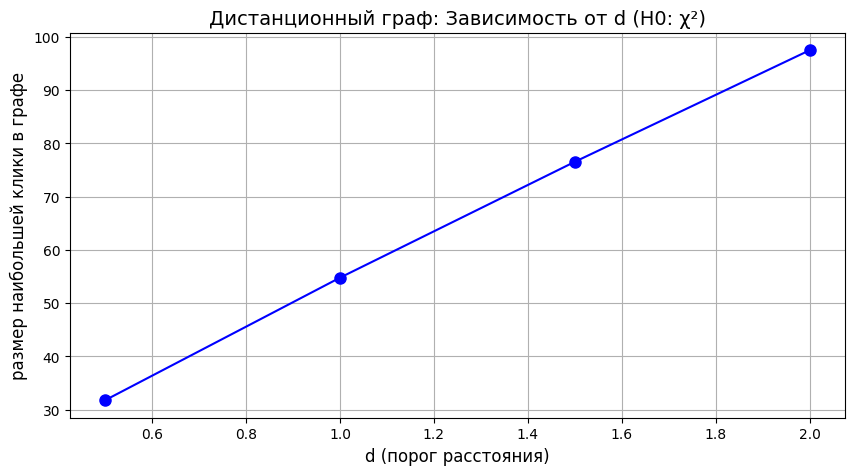

In [20]:
plot_line(
    x_values=d_values,
    y_values=h0_dist_d_stats,
    x_label="d (порог расстояния)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от d (H0: χ²)",
    # color="blue"
)


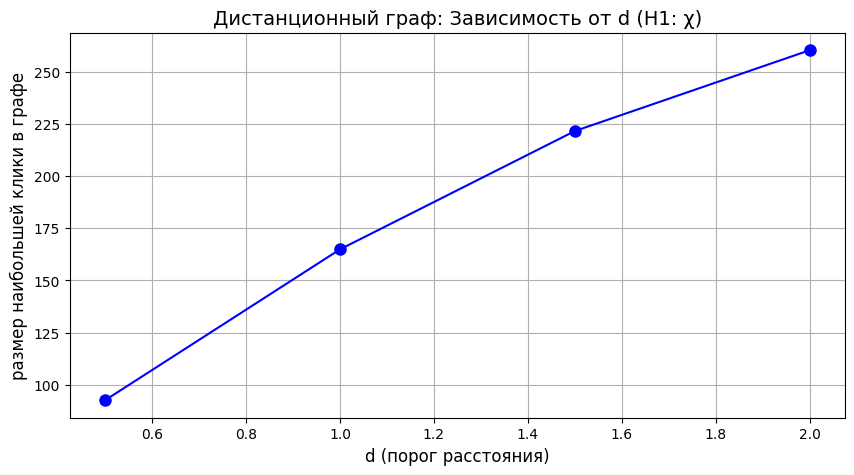

In [21]:
plot_line(
    x_values=d_values,
    y_values=h1_dist_d_stats,
    x_label="d (порог расстояния)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от d (H1: χ)",
    # color="orange"
)


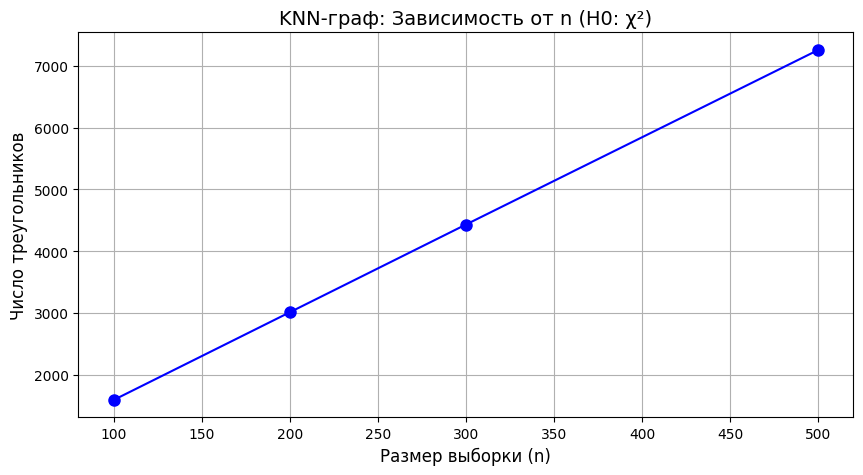

In [22]:
plot_line(
    x_values=n_values,
    y_values=h0_knn_n_stats,
    x_label="Размер выборки (n)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от n (H0: χ²)",
    # color="blue"
)


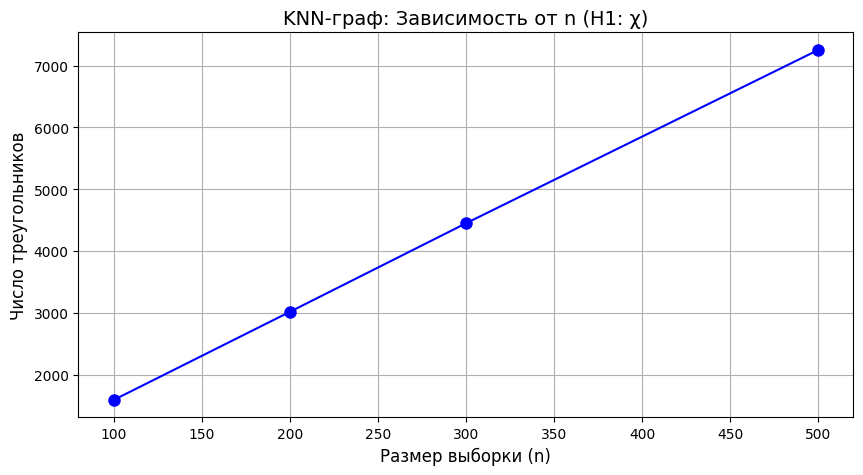

In [23]:
plot_line(
    x_values=n_values,
    y_values=h1_knn_n_stats,
    x_label="Размер выборки (n)",
    y_label="Число треугольников",
    title="KNN-граф: Зависимость от n (H1: χ)",
    # color="orange"
)


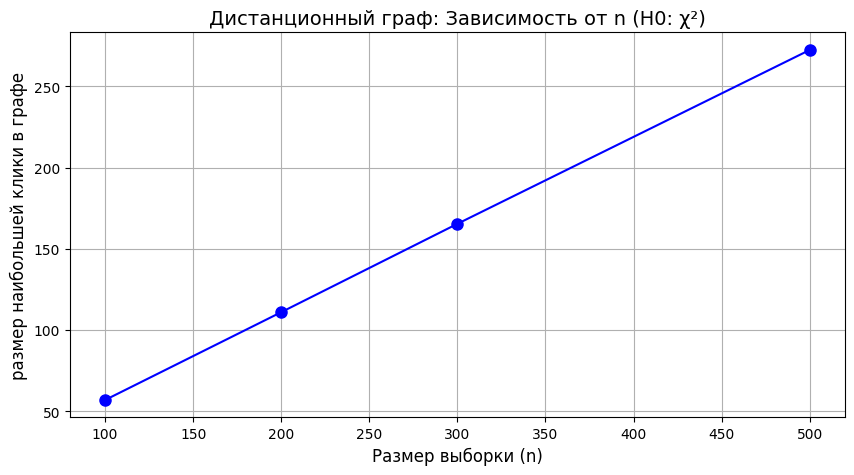

In [24]:
plot_line(
    x_values=n_values,
    y_values=h0_dist_n_stats,
    x_label="Размер выборки (n)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от n (H0: χ²)",
    # color="blue"
)


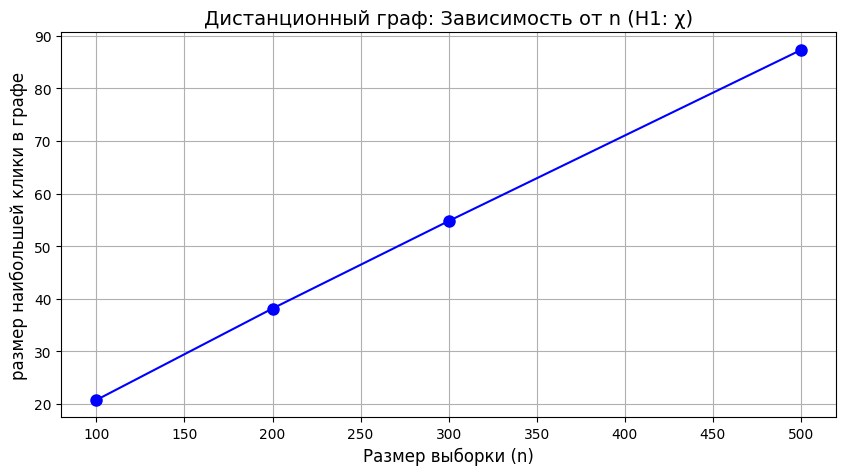

In [25]:
plot_line(
    x_values=n_values,
    y_values=h1_dist_n_stats,
    x_label="Размер выборки (n)",
    y_label="размер наибольшей клики в графе",
    title="Дистанционный граф: Зависимость от n (H1: χ)",
    # color="orange"
)


## Вывод из 2 эксперимента:

### 1. **KNN-граф:**
- Число треугольников **растет** с увеличением `k` (больше соседей → больше связей).
- При увеличении `n` тоже увеличивается.

### 2. **Дистанционный граф:**
 - Кликовое число **увеличивается** с ростом `d` (больший радиус → больше связей).
 - С ростом `n` кликовое число **растет**, так как в выборке появляется больше близких точек.

### 3. **Сравнение графиков KNN и DIST:**
 - KNN: графики характеристик слабо отличаются для h0 и h1.
 - DIST: у графиков существенные различия для h1 и h0(особенно зависимость от d)`.

# Эксперимент 3. Построение критической области и оценка мощности критерия 
## Для каждого типа графа (KNN и дистанционный) построим критическую область A при уровне значимости α=0.05 и оценим мощность критерия.

In [27]:
# Конфигурация
alpha = 0.05  # уровень значимости
theta0 = 5  # Фиксированный параметр распределения для χ²
nu0 = 5  # Аналогично для χ
n = 500  # Размер выборки
k = 10  # Параметр KNN-графа
d = 1.0  # Параметр дистанционного графа
n_samples = 500  # Число симуляций


### KNN-граф (число треугольников)

In [28]:
# Генерация данных для H0 и H1

h0_knn_stats = monte_carlo_simulation(
    generate_chi2,
    {"nu": theta0, "n": n},
    graph_type="knn",
    graph_param=k,
    metric="count_triangles",
    n_samples=n_samples,
)

h1_knn_stats = monte_carlo_simulation(
    generate_chi,
    {"nu": nu0, "n": n},
    graph_type="knn",
    graph_param=k,
    metric="count_triangles",
    n_samples=n_samples,
)


In [29]:
# Построение критической области
_, critical_value_knn = calculate_critical_region(h0_knn_stats, alpha=alpha)
power_knn = estimate_power(h1_knn_stats, critical_value_knn)

print(f"[KNN-граф] Критическое значение: {critical_value_knn:.2f}")
print(f"[KNN-граф] Мощность критерия: {power_knn:.2%}")


[KNN-граф] Критическое значение: 7507.15
[KNN-граф] Мощность критерия: 4.80%


### Дистанционный граф (размер наибольшей клики в графе)


In [31]:
# Генерация данных для H0 и H1
h0_dist_stats = monte_carlo_simulation(
    generate_chi2,
    {"nu": theta0, "n": n},
    graph_type="distance",
    graph_param=d,
    metric="clique_number",
    n_samples=n_samples,
    metric_args={"d": d}
)

h1_dist_stats = monte_carlo_simulation(
    generate_chi,
    {"nu": nu0, "n": n},
    graph_type="distance",
    graph_param=d,
    metric="clique_number",
    n_samples=n_samples,
    metric_args={"d": d}
)


In [32]:
# Построение критической области
_, critical_value_dist = calculate_critical_region(h0_dist_stats, alpha=alpha)
power_dist = estimate_power(h1_dist_stats, critical_value_dist)

print(f"[Дистанционный граф] Критическое значение: {critical_value_dist:.2f}")
print(f"[Дистанционный граф] Мощность критерия: {power_dist:.2%}")


[Дистанционный граф] Критическое значение: 97.05
[Дистанционный граф] Мощность критерия: 100.00%


## Визуализация

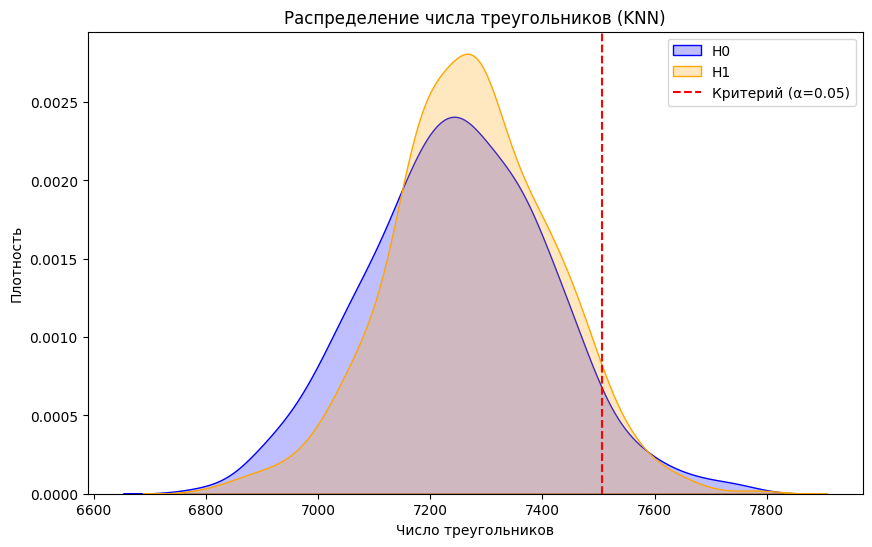

In [33]:
# Для KNN-графа
plot_critical_region(
    h0_knn_stats,
    h1_knn_stats,
    critical_value_knn,
    "Распределение числа треугольников (KNN)",
    "Число треугольников",
)


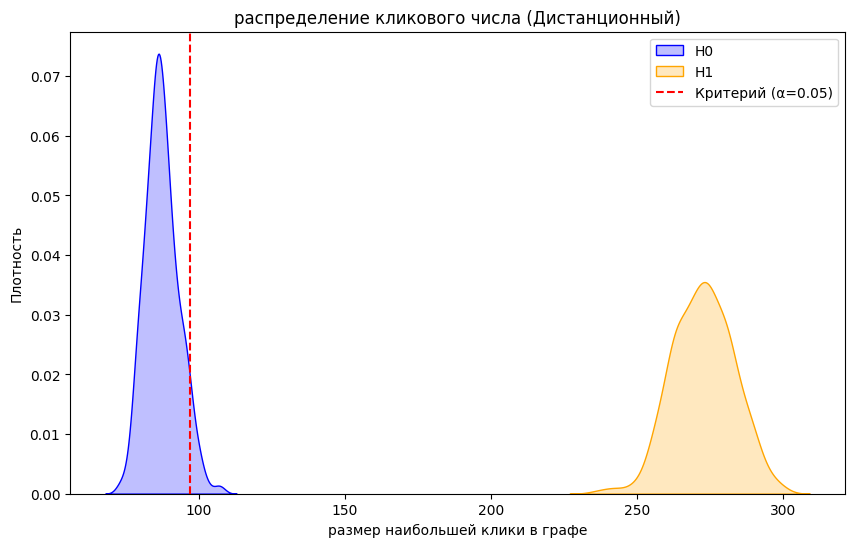

In [34]:
# Для дистанционного графа
plot_critical_region(
    h0_dist_stats,
    h1_dist_stats,
    critical_value_dist,
    "распределение кликового числа (Дистанционный)",
    "размер наибольшей клики в графе",
)


## Дополнительные метрики

In [35]:
from sklearn.metrics import roc_auc_score


def calculate_metrics(h0_stats, h1_stats, critical_value):
    """Вычисляет FPR, TPR, AUC-ROC."""
    # Лейблы: 0 для H0, 1 для H1
    y_true = np.concatenate([np.zeros_like(h0_stats), np.ones_like(h1_stats)])
    y_scores = np.concatenate([h0_stats, h1_stats])

    # FPR и TPR
    fpr = np.mean(h0_stats > critical_value)
    tpr = np.mean(h1_stats > critical_value)

    # AUC-ROC
    auc = roc_auc_score(y_true, y_scores)

    return fpr, tpr, auc


# Для KNN-графа
fpr_knn, tpr_knn, auc_knn = calculate_metrics(
    h0_knn_stats, h1_knn_stats, critical_value_knn
)
print(f"[KNN-граф] FPR: {fpr_knn:.2%}, TPR: {tpr_knn:.2%}, AUC: {auc_knn:.3f}")

# Для дистанционного графа
fpr_dist, tpr_dist, auc_dist = calculate_metrics(
    h0_dist_stats, h1_dist_stats, critical_value_dist
)
print(
    f"[Дистанционный] FPR: {fpr_dist:.2%}, TPR: {tpr_dist:.2%}, AUC: {auc_dist:.3f}"
)


[KNN-граф] FPR: 5.00%, TPR: 4.80%, AUC: 0.545
[Дистанционный] FPR: 5.00%, TPR: 100.00%, AUC: 1.000


## Вывод из 2 эксперимента:
### KNN-граф (число треугольников):
- Низкая мощность (4.80%): Критерий почти не способен обнаружить H1, когда она верна.
- AUC = 0.545, не намного лучше случайного угадывания.

### Дистанционный граф (кликовое число):
- Мощность 100%: Критерий идеально обнаруживает H1.
- AUC = 1.0: Полное разделение H0 и H1